In [1]:
import pathpyG as pp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
from collections import defaultdict, deque
import numpy as np
import time

In [2]:
df = pd.read_csv('email-Eu-core-temporal.txt', sep=" ", header=None, )
df.columns = ['source', 'destination', 'timestamp']
df.head()

,source,destination,timestamp
0,582,364,0
1,168,472,2797
2,168,912,3304
3,2,790,4523
4,2,322,7926


In [3]:
df.dropna(inplace=True)  # Drop rows with missing values

# Convert cleaned DataFrame to list of tuples (source, destination, timestamp)
data_tuples = list(df.itertuples(index=False, name=None))

In [4]:
print(len(df))

332334


In [4]:
# Step 1: Extract and sort timestamps
timestamps = df['timestamp'].sort_values().to_numpy()

# Step 2: Calculate time intervals
intervals = np.diff(timestamps)

# Step 3: Calculate average interval
average_interval = np.mean(intervals)

print(f"Average time interval: {average_interval} seconds")

Average time interval: 209.0049859628746 seconds


In [5]:
# Define the PaCo algorithm
def paco(data, delta, max_length):
    """
    Implements the PaCo algorithm for counting causal paths in temporal networks.
    
    Args:
    - data: List of tuples (source, destination, timestamp).
    - delta: Maximum time difference between consecutive links.
    - max_length: Maximum path length (K).
    
    Returns:
    - path_counts: Dictionary of causal paths and their counts.
    """
    # Sort data by timestamp
    data = sorted(data, key=lambda x: x[2])
    
    # Initialize sliding window and path counters
    window = deque()  # Sliding window
    path_counts = defaultdict(int)  # Overall causal path counts
    
    # Iterate through each link in the data
    for (s, d, t) in data:
        current_counts = defaultdict(int)  # Local counts for current link
        current_counts[(s, d)] = 1  # A single link is a causal path of length 1
        
        # Update the sliding window: remove outdated links
        while window and window[0][2] < t - delta:
            window.popleft()
        
        # Extend paths from the sliding window
        for (prev_s, prev_d, prev_t, prev_counts) in window:
            if prev_d == s and prev_t < t:  # Valid path extension
                for path, count in prev_counts.items():
                    if len(path) < max_length:  # Enforce maximum path length
                        extended_path = path + (d,)
                        current_counts[extended_path] += count
        
        # Update global counts
        for path, count in current_counts.items():
            path_counts[path] += count
        
        # Add current link and its paths to the sliding window
        window.append((s, d, t, current_counts))
    
    return path_counts


In [11]:
delta_values = [6000, 12000, 18000]
max_length_values = [2, 3, 4, 5, 6]

# Loop through the values and measure execution time
for delta in delta_values:
    for max_length in max_length_values:
        start_time = time.time()  # Record start time
        results = paco(data_tuples, delta, max_length)
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time  # Calculate elapsed time
        
        print(f"Max Time Delta: {delta}, Max length: {max_length} -> Time Taken: {elapsed_time:.4f} seconds")

Max Time Delta: 6000, Max length: 2 -> Time Taken: 0.7403 seconds
Max Time Delta: 6000, Max length: 3 -> Time Taken: 0.7859 seconds
Max Time Delta: 6000, Max length: 4 -> Time Taken: 0.8665 seconds
Max Time Delta: 6000, Max length: 5 -> Time Taken: 0.9481 seconds
Max Time Delta: 6000, Max length: 6 -> Time Taken: 1.0305 seconds
Max Time Delta: 12000, Max length: 2 -> Time Taken: 1.1526 seconds
Max Time Delta: 12000, Max length: 3 -> Time Taken: 1.2822 seconds
Max Time Delta: 12000, Max length: 4 -> Time Taken: 1.4803 seconds
Max Time Delta: 12000, Max length: 5 -> Time Taken: 1.6787 seconds
Max Time Delta: 12000, Max length: 6 -> Time Taken: 1.9862 seconds
Max Time Delta: 18000, Max length: 2 -> Time Taken: 1.5194 seconds
Max Time Delta: 18000, Max length: 3 -> Time Taken: 1.8001 seconds
Max Time Delta: 18000, Max length: 4 -> Time Taken: 1.9309 seconds
Max Time Delta: 18000, Max length: 5 -> Time Taken: 2.4347 seconds
Max Time Delta: 18000, Max length: 6 -> Time Taken: 3.0307 seconds


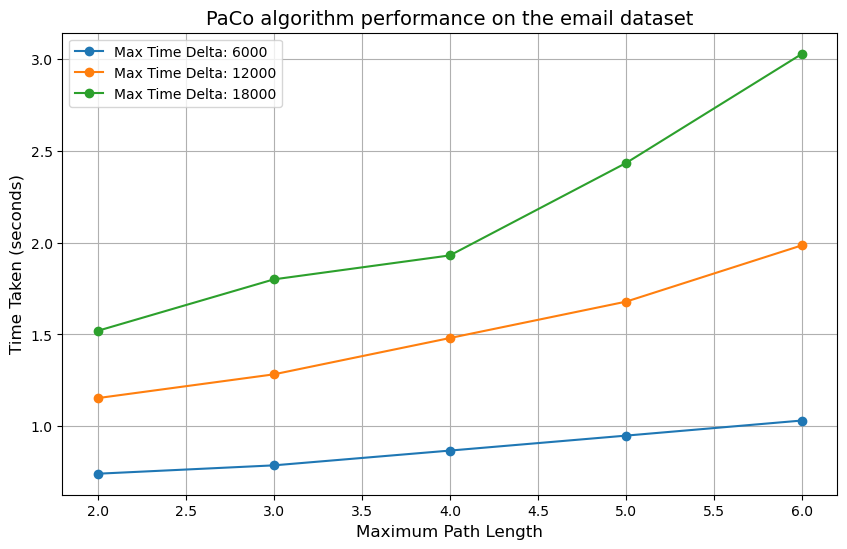

In [15]:
max_lengths = [2, 3, 4, 5, 6]
time_deltas = [6000, 12000, 18000]

times = {
    6000: [0.7403, 0.7859, 0.8665, 0.9481, 1.0305],
    12000: [1.1526, 1.2822, 1.4803, 1.6787, 1.9862],
    18000: [1.5194, 1.8001, 1.9309, 2.4347, 3.0307]
}

# Plotting
plt.figure(figsize=(10, 6))

for delta in time_deltas:
    plt.plot(max_lengths, times[delta], marker='o', label=f'Max Time Delta: {delta}')

# Labels and legend
plt.xlabel('Maximum Path Length', fontsize=12)
plt.ylabel('Time Taken (seconds)', fontsize=12)
plt.title('PaCo algorithm performance on the email dataset', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [19]:
print(len(results))

1524658


In [6]:
G_email = nx.DiGraph()
for index, row in df.iterrows():
    G_email.add_edge(row['source'], row['destination'], timestamp=row['timestamp'])

In [7]:
print(nx.density(G_email))
print(nx.average_clustering(G_email))

0.025667981178118016
0.3727075757887645


In [8]:
call_edge_list = list(df.itertuples(index=False, name=None))
graph = pp.TemporalGraph.from_edge_list(call_edge_list)

In [59]:
delta_values = [6000, 12000, 18000]
max_order_values = [2, 3, 4, 5, 6]

for delta in delta_values:
    for max_order in max_order_values:
        start_time = time.time()  
        temporal_paths = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=max_order)
        end_time = time.time()  
        elapsed_time = end_time - start_time  
        
        print(f"Delta: {delta}, Max Order: {max_order} -> Time Taken: {elapsed_time:.4f} seconds")

100%|██████████| 204865/204865 [01:15<00:00, 2728.14it/s]


Delta: 6000, Max Order: 2 -> Time Taken: 77.7554 seconds


100%|██████████| 204865/204865 [01:13<00:00, 2778.09it/s]


Delta: 6000, Max Order: 3 -> Time Taken: 75.9928 seconds


100%|██████████| 204865/204865 [01:15<00:00, 2704.02it/s]


Delta: 6000, Max Order: 4 -> Time Taken: 79.4468 seconds


100%|██████████| 204865/204865 [01:13<00:00, 2802.17it/s]


Delta: 6000, Max Order: 5 -> Time Taken: 79.2110 seconds


100%|██████████| 204865/204865 [01:15<00:00, 2718.02it/s]


Delta: 6000, Max Order: 6 -> Time Taken: 90.1463 seconds


100%|██████████| 204865/204865 [01:05<00:00, 3131.45it/s]


Delta: 12000, Max Order: 2 -> Time Taken: 66.5098 seconds


100%|██████████| 204865/204865 [01:10<00:00, 2920.69it/s]


Delta: 12000, Max Order: 3 -> Time Taken: 73.1436 seconds


100%|██████████| 204865/204865 [01:01<00:00, 3344.47it/s]


Delta: 12000, Max Order: 4 -> Time Taken: 67.3223 seconds


100%|██████████| 204865/204865 [01:15<00:00, 2730.98it/s]


Delta: 12000, Max Order: 5 -> Time Taken: 89.6361 seconds


100%|██████████| 204865/204865 [01:09<00:00, 2951.75it/s]


Delta: 12000, Max Order: 6 -> Time Taken: 129.9010 seconds


100%|██████████| 204865/204865 [01:14<00:00, 2745.85it/s]


Delta: 18000, Max Order: 2 -> Time Taken: 76.2166 seconds


100%|██████████| 204865/204865 [01:06<00:00, 3065.10it/s]


Delta: 18000, Max Order: 3 -> Time Taken: 70.4611 seconds


100%|██████████| 204865/204865 [01:17<00:00, 2643.15it/s]


Delta: 18000, Max Order: 4 -> Time Taken: 85.8963 seconds


100%|██████████| 204865/204865 [01:13<00:00, 2797.74it/s]


Delta: 18000, Max Order: 5 -> Time Taken: 93.9587 seconds


100%|██████████| 204865/204865 [01:12<00:00, 2831.44it/s]


: 

In [9]:
temporal_paths = pp.MultiOrderModel.from_temporal_graph(graph, delta=18000, max_order=6)

100%|██████████| 204865/204865 [00:52<00:00, 3934.18it/s]


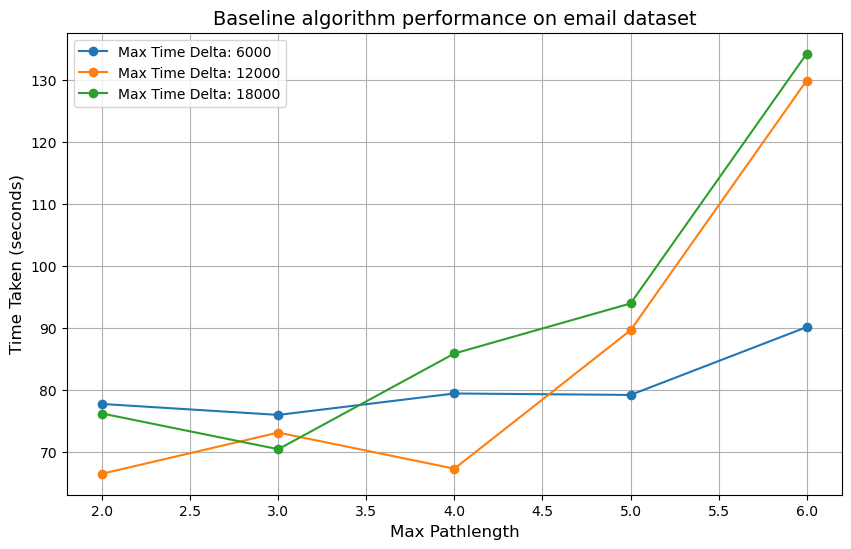

In [2]:
max_orders = [2, 3, 4, 5, 6]
deltas = [6000, 12000, 18000]

times = {
    6000: [77.7554, 75.9928, 79.4468, 79.2110, 90.1463],
    12000: [66.5098, 73.1436, 67.3223, 89.6361, 129.9010],
    18000: [76.2166, 70.4611, 85.8963, 93.9587, 134.2210]
}

# Plotting
plt.figure(figsize=(10, 6))

for delta in deltas:
    plt.plot(max_orders, times[delta], marker='o', label=f'Max Time Delta: {delta}')

# Labels and legend
plt.xlabel('Max Pathlength', fontsize=12)
plt.ylabel('Time Taken (seconds)', fontsize=12)
plt.title('Baseline algorithm performance on email dataset', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [37]:
combined_graph = []
for i in range(1,7):
    paths = temporal_paths.layers[i]
    for path in paths.edges:
        combined_graph.append(path)

In [38]:
print(len(combined_graph))

2468978
